In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn
import triton
import original_quant
import gptq_triton
import json
from matplotlib import pyplot as plt
import numpy as np
from gptq_triton.fused_mlp import llama_mlp_fused_4_kernel
from transformers.models.llama.modeling_llama import LlamaMLP
from gptq_triton.quant_linear import matmul4_kernel

## Benchmark QuantLinear Kernel
Tests the speed of the Triton, CUDA, and FP16 kernels on 4096x4096, 4096x11008, 11008x4096, and 4096x12288 matrices.

4096->4096


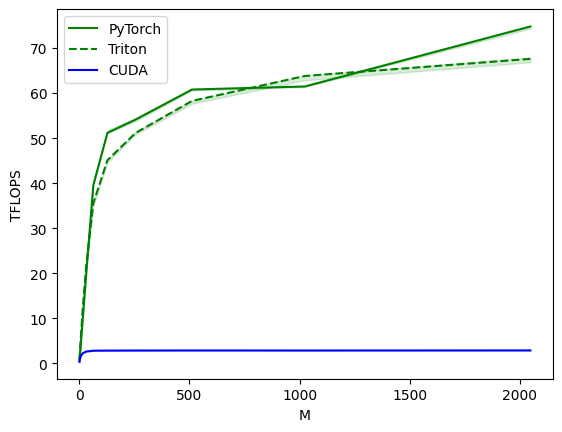

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.668735   0.819200  0.344926
1      2.0   1.236528   1.598439  0.675629
2      4.0   2.473057   3.276800  1.149754
3      8.0   4.946113   6.393756  1.724632
4     16.0   9.892226  12.192744  2.269645
5     32.0  20.164923  21.845333  2.647919
6     64.0  39.568906  35.544948  2.830165
7    128.0  51.150050  45.100042  2.851328
8    256.0  54.120051  51.150050  2.867410
9    512.0  60.787013  58.254220  2.882436
10  1024.0  61.455001  63.791697  2.872811
11  2048.0  74.773106  67.581938  2.893247


4096->11008


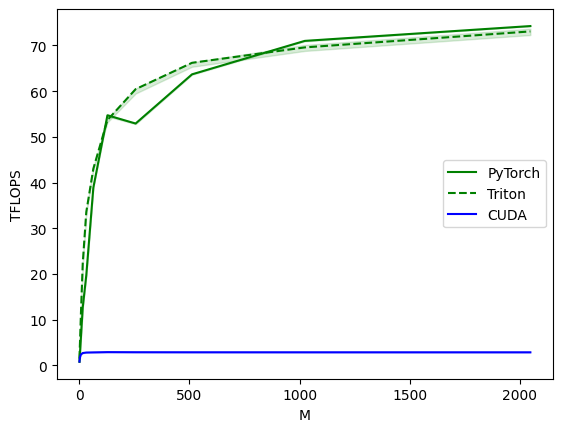

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.752684   1.467733  0.830792
1      2.0   1.601164   2.985220  1.334303
2      4.0   3.202327   5.870933  1.904087
3      8.0   6.404654  11.741867  2.396299
4     16.0  12.693910  22.365460  2.688977
5     32.0  19.706630  33.548191  2.798459
6     64.0  38.869628  43.023636  2.833633
7    128.0  54.719379  53.677105  2.891047
8    256.0  52.921088  60.440710  2.869703
9    512.0  63.684703  66.209644  2.858151
10  1024.0  71.005933  69.581434  2.854984
11  2048.0  74.250747  73.077422  2.851283


11008->4096


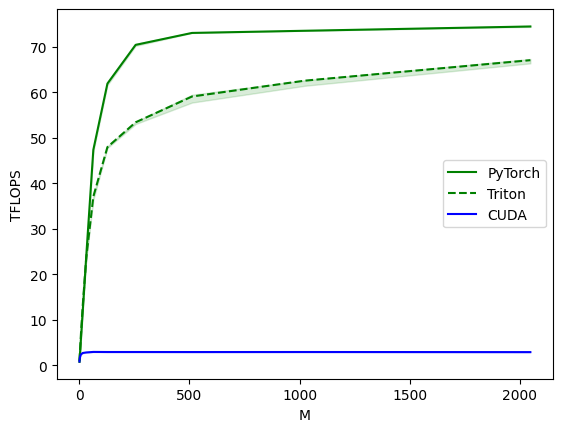

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.727802   0.926989  0.823028
1      2.0   1.518345   1.815753  1.324271
2      4.0   3.010735   3.522560  1.904087
3      8.0   6.021470   7.045120  2.388176
4     16.0  12.042940  13.168449  2.683855
5     32.0  24.085880  23.681076  2.806821
6     64.0  47.362153  37.079581  2.920257
7    128.0  61.935120  47.966775  2.902960
8    256.0  70.451202  53.422709  2.902960
9    512.0  73.077422  59.094061  2.894016
10  1024.0  73.554269  62.579829  2.902773
11  2048.0  74.496104  67.083900  2.879599


4096->12288


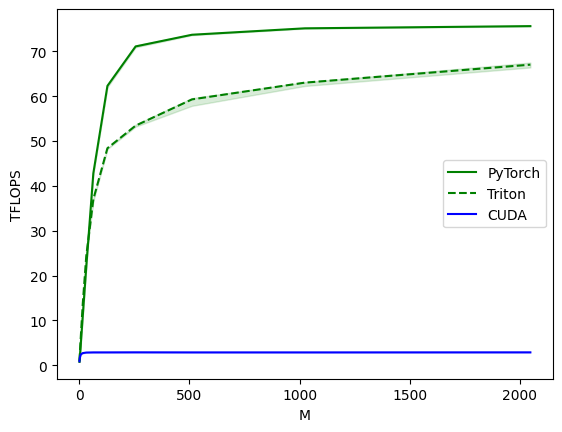

matmul:
         M    PyTorch     Triton      CUDA
0      1.0   0.762047   0.936229  0.901872
1      2.0   1.384563   1.854792  1.424696
2      4.0   2.749762   3.674916  1.996020
3      8.0   5.461333   7.084973  2.473057
4     16.0  10.999049  13.677078  2.721218
5     32.0  21.998098  24.385490  2.844239
6     64.0  42.799021  37.008565  2.879385
7    128.0  62.291645  48.395815  2.881693
8    256.0  71.089901  53.430623  2.895952
9    512.0  73.692015  59.283449  2.879056
10  1024.0  75.121865  63.013020  2.877944
11  2048.0  75.615624  67.019503  2.891751


In [2]:
matmul4_kernel.record_detailed_timings = True


def benchmarker(M, N, K, provider):
	layer = nn.Linear(K, N)
	vec = torch.randn(M, K, device='cuda', dtype=torch.float16)

	quantizer = original_quant.Quantizer()
	quantizer.configure(4, perchannel=True, sym=False, mse=False)
	quantizer.find_params(layer.weight.data, weight=True)
	layer.weight.data = original_quant.quantize(layer.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq)

	cuda_layer = original_quant.QuantLinear(4, -1, layer.in_features, layer.out_features)
	cuda_layer.pack(layer, quantizer.scale, quantizer.zero)

	# Convert layer to 16-bit
	layer = layer.half()

	# Convert cuda_layer to Triton
	state_dict = cuda_layer.state_dict()
	state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
	del state_dict['bias']
	triton_layer = gptq_triton.QuantLinear(4, -1, layer.in_features, layer.out_features, bias=False)
	triton_layer.load_state_dict(state_dict)

	# Move to GPU
	layer = layer.to('cuda')
	cuda_layer = cuda_layer.to('cuda')
	triton_layer = triton_layer.to('cuda')

	if provider == 'torch':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_layer(vec))
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_layer(vec))
	
	perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
	return perf(ms), perf(max_ms), perf(min_ms)


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 4096, provider)

print("4096->4096")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 11008, 4096, provider)

print("4096->11008")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 11008, provider)

print("11008->4096")
benchmark.run(show_plots=True, print_data=True)
print()
print()


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['torch', 'triton', 'cuda'],
		line_names=['PyTorch', 'Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='TFLOPS',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, 12288, provider)

print("4096->12288")
benchmark.run(show_plots=True, print_data=True)

## Benchmark In-Situ
Benchmark Triton and CUDA kernels in the model itself. This is useful because sometimes the Triton kernel is faster in isolation, but performs worse within the context of the model.

In [3]:
# Load the models
cuda_model = original_quant.load_cuda_quant('../weights/HF/llama-7b', '../GPTQ-for-LLaMa/llama7b-4bit-128g-2.pt', 4, -1)
cuda_model.eval()
cuda_model = cuda_model.to('cuda')

model = gptq_triton.load_quant('../weights/llama-7b-4bit', fuse_mlp=False)
model.eval()
model = model.to('cuda')

Loading model ...
Done.
Loading model ...
QuantLinear Warmup: Found 4 unique KN values.
FusedMLP Warmup: Found 0 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:12<00:00,  1.05s/it]

Done.


Lower is better


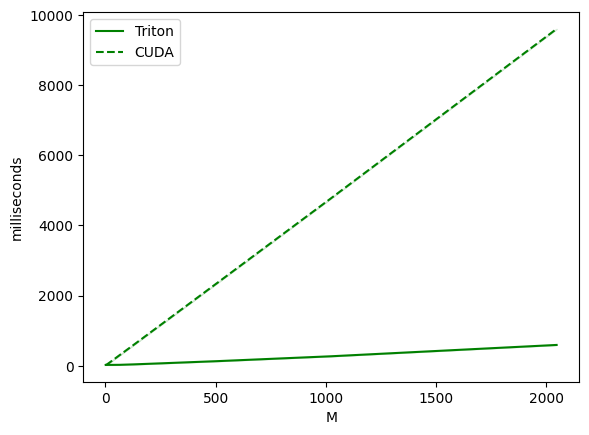

matmul:
         M      Triton         CUDA
0      1.0   22.654976    24.373247
1      2.0   23.524351    25.581568
2      4.0   23.857153    27.245567
3      8.0   23.766016    42.013695
4     16.0   23.772671    78.430206
5     32.0   23.723007   151.201279
6     64.0   25.224192   300.380157
7    128.0   38.224895   594.778076
8    256.0   68.721664  1190.277588
9    512.0  131.376648  2382.546387
10  1024.0  269.100037  4776.160156
11  2048.0  592.441833  9607.062500




In [4]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		position_ids = torch.arange(0, M, dtype=torch.long, device=inputs_embeds.device)
		position_ids = position_ids.unsqueeze(0).view(-1, M)
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				position_ids=position_ids,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'torch':
		raise NotImplementedError
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)
	elif provider == 'triton':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['triton', 'cuda'],
		line_names=['Triton', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Visualize `benchmark_generate.py` Results
Run `benchmark_generate.py` and save the results to `results-triton.jsonl` and `results-cuda.jsonl`.  Then run this cell to visualize the results.

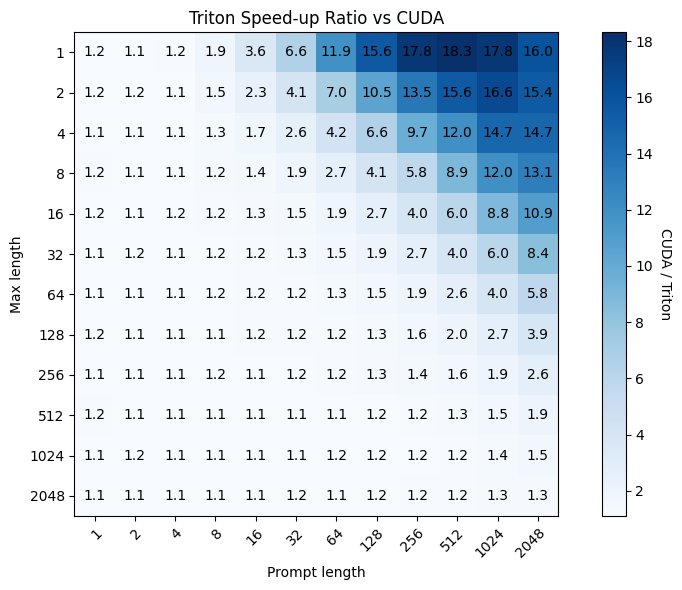

Minimum speed-up: 110.5%
Maximum speed-up: 1831.3%


In [5]:
def read_results(filename):
	with open(filename, 'r') as f:
		results = [json.loads(line) for line in f]
		results = sorted(results, key=lambda x: (x['prompt_length'], x['max_length']))
	return results


# Read the results
triton_results = read_results('results-triton.jsonl')
cuda_results = read_results('results-cuda.jsonl')

# Results as a 2D heatmap
x = sorted(list(set(a['prompt_length'] for a in triton_results)))
y = sorted(list(set(a['max_length'] for a in triton_results)))

z1 = lambda x, y: next(a for a in triton_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z2 = lambda x, y: next(a for a in cuda_results if a['prompt_length'] == x and a['max_length'] == y)['average_time']
z = lambda x, y: z2(x, y) / z1(x, y)

# Draw a heatmap with numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
im = ax.imshow([[z(i, j) for i in x] for j in y], cmap='Blues')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('CUDA / Triton', rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(x)), labels=x)
ax.set_yticks(np.arange(len(y)), labels=y)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(x)):
	for j in range(len(y)):
		text = ax.text(i, j, f'{z(x[i], y[j]):.1f}', ha="center", va="center", color="black")

# Label axes
ax.set_xlabel('Prompt length')
ax.set_ylabel('Max length')

ax.set_title("Triton Speed-up Ratio vs CUDA")
f.tight_layout()
plt.show()

# Print some stats
print(f"Minimum speed-up: {(min(z(i, j) for i in x for j in y) * 100):.1f}%")
print(f"Maximum speed-up: {(max(z(i, j) for i in x for j in y) * 100):.1f}%")

## Benchmark Fused MLP Kernel

Lower is better


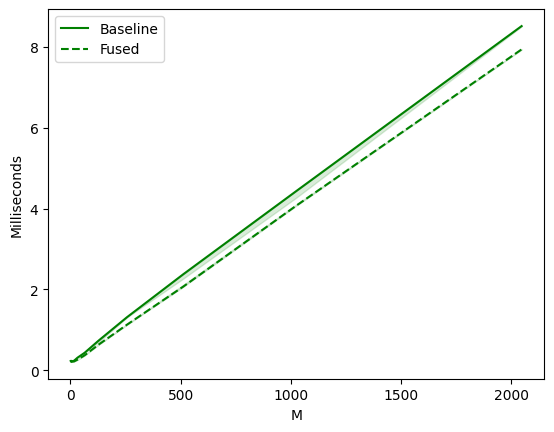

matmul:
         M  Baseline     Fused
0      1.0  0.231424  0.208896
1      2.0  0.217088  0.210944
2      4.0  0.220160  0.212992
3      8.0  0.226304  0.216064
4     16.0  0.236544  0.220160
5     32.0  0.313344  0.264192
6     64.0  0.432640  0.370688
7    128.0  0.736256  0.636928
8    256.0  1.310720  1.126400
9    512.0  2.374656  2.069504
10  1024.0  4.426752  4.066304
11  2048.0  8.509440  7.933440


In [6]:
llama_mlp_fused_4_kernel.record_detailed_timings = True


def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)
	layer = LlamaMLP(4096, 11008, 'silu')
	layer = layer.half()

	# Quantize linear layers
	for name, m in layer.named_modules():
		if not isinstance(m, nn.Linear):
			continue

		quantizer = original_quant.Quantizer()
		quantizer.configure(4, perchannel=True, sym=False, mse=False)
		quantizer.find_params(m.weight.data, weight=True)
		m.weight.data = original_quant.quantize(m.weight.data, quantizer.scale, quantizer.zero, quantizer.maxq).to(torch.float16)

		qlayer = original_quant.QuantLinear(4, -1, m.in_features, m.out_features)
		qlayer.pack(m, quantizer.scale, quantizer.zero)
		state_dict = qlayer.state_dict()

		tritonlayer = gptq_triton.QuantLinear(4, -1, m.in_features, m.out_features, bias=False)
		state_dict['scales'] = state_dict['scales'].to(torch.float16, copy=True)
		del state_dict['bias']
		tritonlayer.load_state_dict(state_dict)

		setattr(layer, name, tritonlayer)

	# Fuse
	fused_layer = gptq_triton.make_fused_mlp(layer)
	assert isinstance(fused_layer, gptq_triton.QuantLlamaMLP)

	# Move to CUDA
	layer.to('cuda')
	fused_layer.to('cuda')

	if provider == 'baseline':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: layer(vec))
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: fused_layer(vec))
	
	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['baseline', 'fused'],
		line_names=['Baseline', 'Fused'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)

## Benchmark Fused MLP In-Situ

In [7]:
# Load the models
fused_model = gptq_triton.load_quant('../weights/llama-7b-4bit', fuse_mlp=True)
fused_model.eval()
fused_model = fused_model.to('cuda')

Loading model ...
QuantLinear Warmup: Found 3 unique KN values.
FusedMLP Warmup: Found 1 unique K values.
Warming up autotune cache ...


100%|██████████| 12/12 [00:00<00:00, 3620.72it/s]

Done.


Lower is better


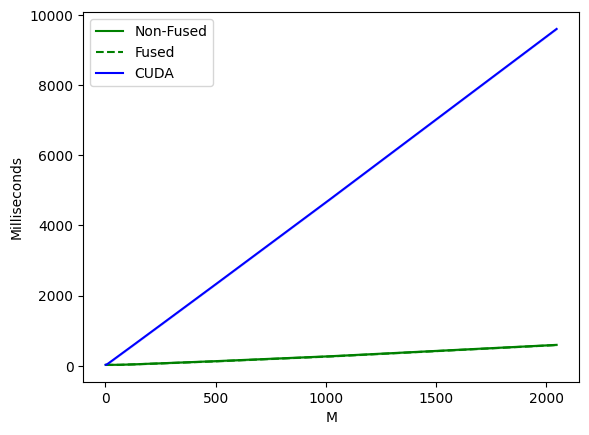

matmul:
         M   Non-Fused       Fused         CUDA
0      1.0   22.609921   20.752895    24.552448
1      2.0   23.667200   21.911552    25.474049
2      4.0   23.761921   22.090240    25.886721
3      8.0   23.890944   23.100414    42.053631
4     16.0   23.725056   22.082047    78.413826
5     32.0   23.840769   22.230528   151.366150
6     64.0   25.337856   23.571457   298.748932
7    128.0   38.279167   36.418560   593.321472
8    256.0   69.128189   65.164291  1185.967041
9    512.0  132.158463  125.778946  2375.265625
10  1024.0  270.375946  263.580658  4767.345703
11  2048.0  593.451050  588.170227  9604.912109




In [8]:
def benchmarker(M, K, provider):
	vec = torch.randn(1, M, K, device='cuda', dtype=torch.float16)

	def runfoo(inputs_embeds, model):
		position_ids = torch.arange(0, M, dtype=torch.long, device=inputs_embeds.device)
		position_ids = position_ids.unsqueeze(0).view(-1, M)
		attention_mask = torch.ones(
			(1, M), dtype=torch.bool, device=inputs_embeds.device
		)
		attention_mask = model.model._prepare_decoder_attention_mask(
			attention_mask, (1, M), inputs_embeds, 0
		)

		hidden_states = inputs_embeds

		for idx, decoder_layer in enumerate(model.model.layers):
			layer_outputs = decoder_layer(
				hidden_states,
				attention_mask=attention_mask,
				position_ids=position_ids,
				past_key_value=None,
				output_attentions=False,
				use_cache=False,
			)

			hidden_states = layer_outputs[0]
		
		return hidden_states

	if provider == 'non-fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, model), rep=10000)
	elif provider == 'fused':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, fused_model), rep=10000)
	elif provider == 'cuda':
		ms, min_ms, max_ms = triton.testing.do_bench(lambda: runfoo(vec, cuda_model), rep=10000)

	return ms, max_ms, min_ms


@triton.testing.perf_report(
	triton.testing.Benchmark(
		x_names=['M'],
		x_vals=[
			1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048,
		],
		line_arg='provider',
		line_vals=['non-fused', 'fused', 'cuda'],
		line_names=['Non-Fused', 'Fused', 'CUDA'],
		styles=[('green', '-'), ('green', '--'), ('blue', '-'), ('blue', '--')],
		ylabel='Milliseconds',
		plot_name='matmul',
		args={},
	)
)
def benchmark(M, provider):
	return benchmarker(M, 4096, provider)

print("Lower is better")
benchmark.run(show_plots=True, print_data=True)
print()
print()

## Detailed Timings
By enabling `record_detailed_timings` on a kernel's autotune, we can get a detailed breakdown of how each configuration performs.  My methodology is to enable all configurations, run the benchmark, and then use the information printed here to select the smallest set of configurations that are useful.

In [9]:
def config_to_str(config):
	kwargs = ', '.join(f"'{k}': {v}" for k,v in config.kwargs.items())
	return f"{{{kwargs}}}, num_stages={config.num_stages}, num_warps={config.num_warps}"

def print_detailed_timings(kernel):
	for k, timing in kernel.detailed_timings.items():
		# Sort timing
		timing = sorted(timing.items(), key=lambda x: x[1][0])
		print(f'{k}:')

		best = timing[0][1][0]

		for config, (ms, min_ms, max_ms) in timing[:4]:
			ratio = ms / best
			if ratio > 1.05:
				break
			print(f'  {config_to_str(config)}: {ratio:.2f}x')
		print()


print("Detailed timings for matmul4_kernel:")
print_detailed_timings(matmul4_kernel)
print()
print("----------------------------------------")
print()

print("Detailed timings for llama_mlp_fused_4_kernel:")
print_detailed_timings(llama_mlp_fused_4_kernel)

Detailed timings for matmul4_kernel:
(1, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(2, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(4, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(8, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(16, 4096, 4096):
  {'BLOCK_SIZE_M': 16, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(32, 4096, 4096):
  {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(64, 4096, 4096):
  {'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=2, num_warps=4: 1.00x

(128, 4096, 409